In [1]:
import gzip
import numpy as np
from scipy import stats, optimize

import astropy.units as u
from astropy.visualization import hist
from astropy.io import fits
from matplotlib import cm


import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm

from gunagala import camera, optical_filter, optic, psf, sky, imager, utils

from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import Distance

import sys
sys.path.append('../')

%matplotlib inline

/Users/lspitler/miniconda3/envs/metah/lib/python3.6/site-packages/gunagala/imager.py:11: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/lspitler/miniconda3/envs/metah/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/lspitler/miniconda3/envs/metah/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/lspitler/miniconda3/envs/metah/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/lspitler/miniconda3/envs/metah/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/lspitler/minicon

In [2]:
rcParams['figure.figsize'] = (12,8)

### Setup a standard 5-lens imager system to get the default parameters.

In [3]:
imagers = imager.create_imagers()
huntsman = imagers['canon_sbig_dark'] # A 5 lens (per filter) array, dark of Moon

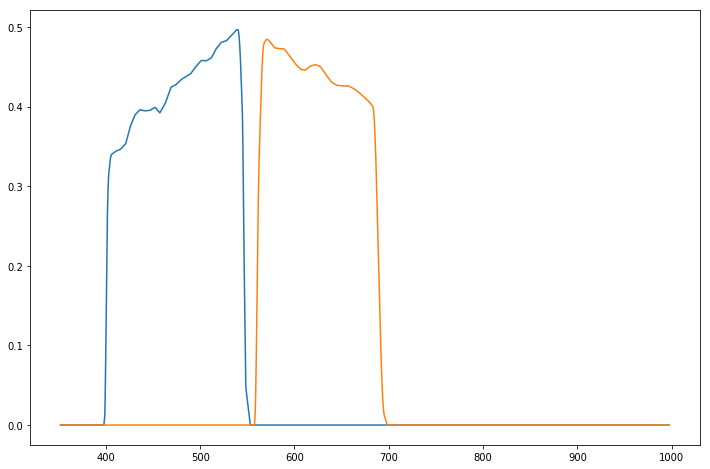

In [4]:
plt.plot(huntsman.wavelengths, huntsman.efficiencies['g'])
plt.plot(huntsman.wavelengths, huntsman.efficiencies['r'])

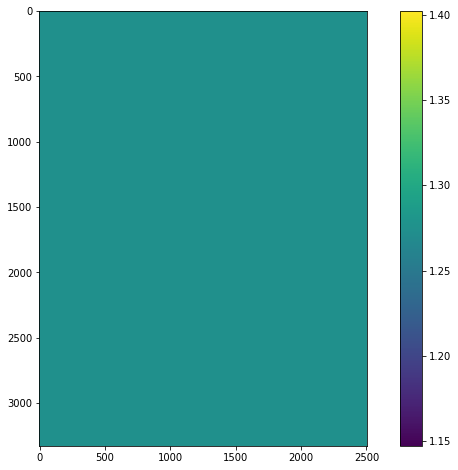

In [5]:
sky_image = huntsman.make_noiseless_image(centre='14h41m -60d54m',
                                         obs_time='2018-04-12T08:00',
                                         filter_name='g')

plt.imshow(sky_image)
plt.colorbar()

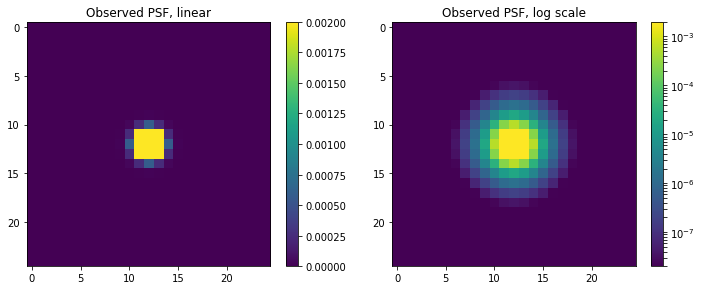

In [6]:
huntsman.psf.n_pix

pixellated_psf = huntsman.psf.pixellated(size=(25, 25), offsets=(0, 0))

plt.subplot(1,2,1)
plt.imshow(pixellated_psf, vmin=0, vmax=2e-3, interpolation='nearest')
plt.colorbar()
plt.title('Observed PSF, linear')
plt.subplot(1,2,2)
plt.imshow(pixellated_psf, norm=LogNorm(), vmin=2e-8, vmax=2e-3)
plt.colorbar()
plt.title('Observed PSF, log scale')

plt.gcf().set_size_inches(12, 4.5)

### Load and prepare simulation data

In [7]:
galaxy_sim_data_raw = fits.open('mw02.fits.gz')[0].data
#galaxy_sim_data_raw[(galaxy_sim_data_raw == 0)] = 9e-99 # get rid of zeros
galaxy_sim_data_denorm = galaxy_sim_data_raw / 6.46174e-6 # this might not be necessary in Chris' later simulation data
# 0.96031355E06 Msol/h, where h=0.705
galaxy_sim_data_mass = galaxy_sim_data_denorm * 0.96031355E06 * .705 # 0.96031355E06 Msol/h, where h=0.705
total_mass_sim = np.sum(galaxy_sim_data_mass)
galaxy_sim_data_raw.shape

(300, 300)

In [23]:
m2l = 5. # assume g_band M/L
M_sun = 5.11 # AB mag http://mips.as.arizona.edu/~cnaw/sun.html

# simulation input: 170 pc / pixel
sim_pc_pixel = 170. * u.parsec / u.pixel

# As if at z=0.0085, D_luminosity = 36 Mpc, m-M=32.8045
# http://cosmocalc.icrar.org/
d = Distance(10. * u.Mpc)
z = d.compute_z(cosmo)

angular_pc = cosmo.kpc_proper_per_arcmin(z).to(u.parsec / u.arcsec)
mM = cosmo.distmod(z)
sim_arcsec_pixel = sim_pc_pixel / angular_pc


print(angular_pc)
print(huntsman.pixel_scale)
print(mM)
print(sim_arcsec_pixel)

48.25834261636264 pc / arcsec
2.8486699583997965 arcsec / pix
30.000000024400038 mag
3.5227069721693924 arcsec / pix


In [9]:
# check to see if sensible first
print('total stellar mass: ', np.log10(total_mass_sim))

total_gband_lum_sim = total_mass_sim / m2l
total_gband_absolute_ABmag_sim = -2.5*np.log10(total_gband_lum_sim) * u.ABmag + M_sun * u.ABmag 
total_gband_apparent_ABmag_sim = total_gband_absolute_ABmag_sim + mM

print('total absolute g-band magnitude: ', total_gband_absolute_ABmag_sim)
print('total apparent g-band magnitude: ', total_gband_apparent_ABmag_sim)


total stellar mass:  11.0202526944
total absolute g-band magnitude:  -20.69320672512778 mag(AB2)
total apparent g-band magnitude:  9.306793299272258 mag(AB2)


### Create a few plots to illustrate simulation requirements

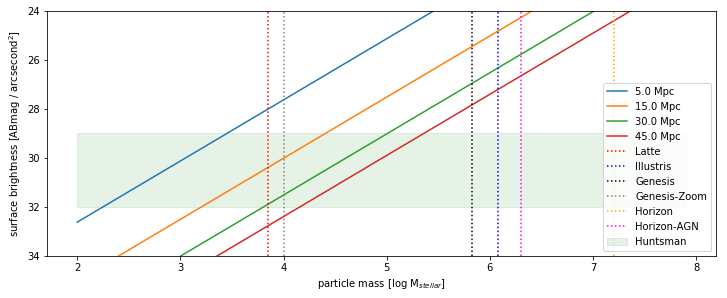

In [118]:
ds = np.array([5.,15,30,45])
ds = Distance(ds * u.Mpc)
zs = []
for d in ds:
    zs.append(d.compute_z(cosmo))
mMs = cosmo.distmod(np.array(zs))

masses = np.arange(2,8,.1)
lights = 10**masses / m2l
absolute_ABmag = -2.5*np.log10(lights) * u.ABmag + M_sun * u.ABmag 

for mM, dist in zip(mMs, ds):
    apparent_ABmag = absolute_ABmag + mM
    sb_ABmag = apparent_ABmag +2.5*np.log10(huntsman.pixel_area.value) * u.ABmag
    plt.plot(masses, sb_ABmag, label=dist)

#plt.fill_between(masses,15,29,color='grey',alpha=.1)
plt.fill_between(masses,29,32,color='green',alpha=.1, label='Huntsman')

plt.axvline(np.log10(7070), ls=':', color='red', label='Latte')
plt.axvline(np.log10(12e5), ls=':', color='blue', label='Illustris')
plt.axvline(np.log10(0.96031355E06 * .705), ls=':', color='black', label='Genesis')
plt.axvline(np.log10(1e4), ls=':', color='grey', label='Genesis-Zoom')
plt.axvline(np.log10(8e7/5.), ls=':', color='orange', label='Horizon')
plt.axvline(np.log10(2e6), ls=':', color='magenta', label='Horizon-AGN')


plt.xlabel('particle mass [log M$_{stellar}$]')
plt.ylabel('surface brightness [ABmag / arcsecond$^2$]')
plt.legend()
plt.ylim(34,24)
plt.gcf().set_size_inches(12, 4.5)

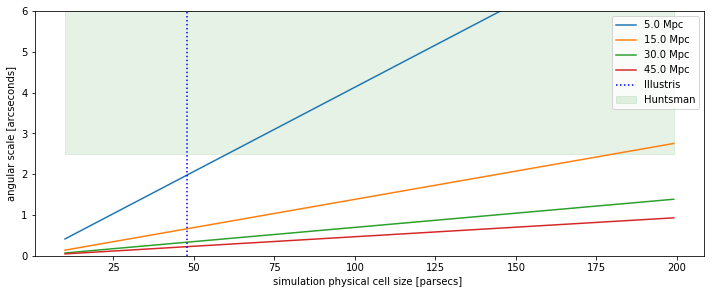

In [107]:
spatials = np.arange(10,200,1) * u.parsec # per particle

mM = cosmo.distmod(z)


for z, dist in zip(zs, ds):
    angular_pc = cosmo.kpc_proper_per_arcmin(z).to(u.parsec / u.arcsec)
    arcsec_pixel = spatials / angular_pc
    plt.plot(spatials, arcsec_pixel, label=dist)


plt.fill_between(spatials,2.5,6,color='green',alpha=.1, label='Huntsman')

plt.axvline(48, ls=':', color='blue', label='Illustris')


plt.xlabel('simulation physical cell size [parsecs] ')
plt.ylabel('angular scale [arcseconds]')
plt.legend()
plt.ylim(0,6)
plt.gcf().set_size_inches(12, 4.5)


### Hack to use gunagala as a way to place a simulated galaxy into Huntsman images
Replace PSF with galaxy simulation, then place a "star" using that galaxy PSF to put it into an image. Eventually placing a galaxy might be its own function. Will need to convolve the real Huntsman PSF with the galaxy simulation data before placing into Huntsman image too.

In [37]:
# hack it as a quick way to scale a galaxy in the correct way
galaxy_psf = psf.PixellatedPSF(galaxy_sim_data_raw,
                               psf_sampling=sim_arcsec_pixel,
                               oversampling=1,
                               psf_centre=(150, 150))
huntsman_galaxy = imager.Imager(optic=huntsman.optic,
                        camera=huntsman.camera,
                        filters=huntsman.filters,
                        psf=galaxy_psf,
                        sky=huntsman.sky)

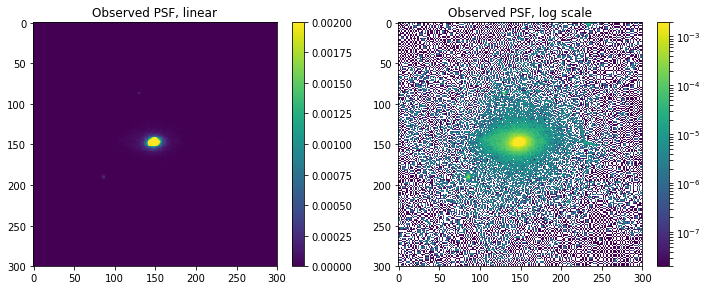

In [39]:
pixellated_psf = huntsman_galaxy.psf.pixellated(size=(300,300), offsets=(0.1, 0.1))

plt.subplot(1,2,1)
plt.imshow(pixellated_psf, vmin=0, vmax=2e-3, interpolation='nearest')
plt.colorbar()
plt.title('Observed PSF, linear')
plt.subplot(1,2,2)
plt.imshow(pixellated_psf, norm=LogNorm(), vmin=2e-8, vmax=2e-3)
plt.colorbar()
plt.title('Observed PSF, log scale')

plt.gcf().set_size_inches(12, 4.5)

In [40]:
# bug? Not sure why the results are S/N= 0/0 ??
huntsman_galaxy.point_source_signal_noise(brightness=12. * u.ABmag,
                                  filter_name='g',
                                  total_exp_time=10000 * u.s,
                                  sub_exp_time=10000 * u.s)

(<Quantity 0.0 electron>, <Quantity 0.0 electron>)

##### About to place the galaxy into a noiseless image
Two bugs exist as of June 2018 in gunagala which should be noted before running the next cell:
 - https://github.com/AstroHuntsman/gunagala/issues/18
 - https://github.com/AstroHuntsman/gunagala/issues/17

If the issues are closed, then maybe the `get_pixel_coords` call below is not needed. For the 1st issue, you'll have to edit the source code directly of gunagala and swap the variable names. Reset kernel and then re-run.

In [47]:
#need to run the following to set the CRvals in the WCS for some reason
#created an issue on github about it
tmp = huntsman_galaxy.get_pixel_coords('14h40m56.435s -60d53m48.3s')
alpha_cen_image = huntsman_galaxy.make_noiseless_image(centre='14h40m56.435s -60d53m48.3s',
                                               obs_time='2018-04-12T08:00',
                                               filter_name='g',
                                               stars=[('14h40m56.435s -60d53m48.3s', total_gband_apparent_ABmag_sim.value)])

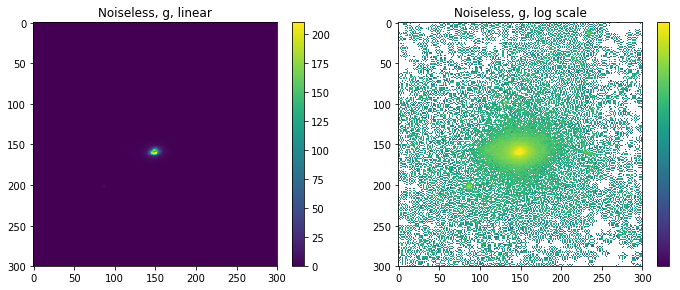

In [48]:
sky_background = np.median(alpha_cen_image[1500:1800,1100:1400])

plt.subplot(1,2,1)
plt.imshow(alpha_cen_image[1500:1800,1100:1400] - sky_background, vmin=0)
plt.colorbar()
plt.title('Noiseless, g, linear')
plt.subplot(1,2,2)
plt.imshow(alpha_cen_image[1500:1800,1100:1400] - sky_background, norm=LogNorm())#, vmin=2e1, vmax=2e5)
plt.colorbar()
plt.title('Noiseless, g, log scale')
plt.gcf().set_size_inches(12, 4.5)
#plt.savefig('../figures/noiseless.png', dpi=200)

/Users/lspitler/miniconda3/envs/metah/lib/python3.6/site-packages/astropy/units/function/logarithmic.py:44: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


Text(0.5,1,'Noiseless, g, linear')

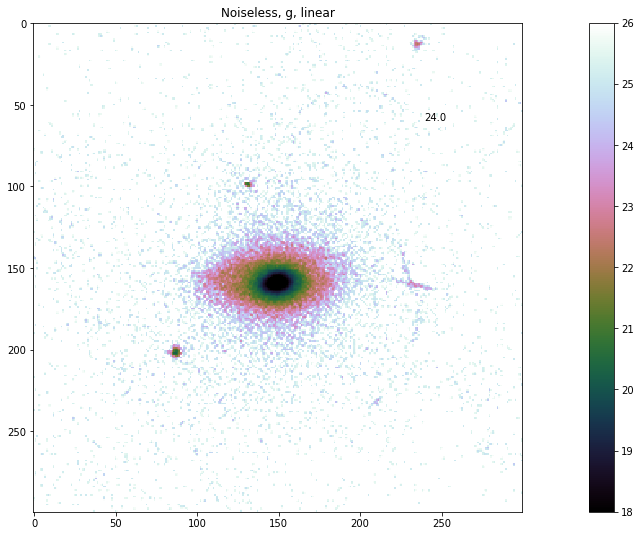

In [49]:
sb_image = huntsman_galaxy.rate_to_SB(alpha_cen_image[1500:1800,1100:1400].data - sky_background, 'g')
is_nan = np.isnan(sb_image)
sb_image[is_nan] = 50. * sb_image.unit

faint_mag = 26.

plt.figure(figsize=(12*2, 4.5*2))
ax = plt.subplot(1,1,1)
plt.imshow(sb_image.data, vmin=18, vmax=faint_mag, cmap=cm.cubehelix)
ax.text(.8, .8, faint_mag-2, transform = ax.transAxes)
plt.colorbar()
plt.title('Noiseless, g, linear')
#plt.subplot(1,2,2)
#plt.imshow(sb_image[(np.not(np.isnan(sb_image)))], norm=LogNorm())#, vmin=2e1, vmax=2e5)
#plt.colorbar()
#plt.title('Noiseless, g, log scale')
#ax.set_size_inches(12, 4.5)
#plt.savefig('../figures/noiseless.png', dpi=200)

In [50]:
hdu = fits.PrimaryHDU(sb_image.value)
hdu.writeto('sb.fits', overwrite=True)

### Add noise to individual mock exposures and co-add them

In [115]:
n_exposures = 100
exptime = 500 * u.s

single_exp = huntsman_galaxy.make_image_real(alpha_cen_image, exptime)
coadd = huntsman_galaxy.make_image_real(alpha_cen_image, exptime)
data_min = np.median(coadd.data)

coadd = coadd[1500:1800,1100:1400] - data_min

for i in range(n_exposures):
    coadd = coadd + (huntsman_galaxy.make_image_real(alpha_cen_image, exptime).data[1500:1800,1100:1400] - data_min)
coadd = coadd / n_exposures


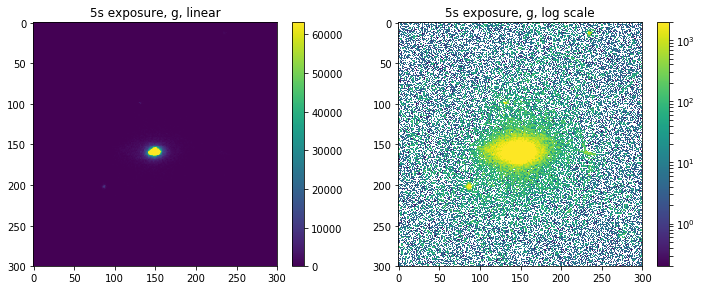

In [116]:
plt.subplot(1,2,1)
plt.imshow((coadd * u.adu).value, vmin=0)
plt.colorbar()
plt.title('5s exposure, g, linear')
plt.subplot(1,2,2)
plt.imshow((coadd * u.adu).value, norm=LogNorm(), vmin=2e-1, vmax=2e3)
print()
plt.colorbar()
plt.title('5s exposure, g, log scale')
plt.gcf().set_size_inches(12, 4.5)
#plt.savefig('../figures/alpha_cen_5ms.png', dpi=200)

In [121]:
#coadd.wcs
#coadd.header['EXPTIME']
#coadd.header['EXPTIME'] = str(coadd.header['EXPTIME'].to(u.second) * n_exposures)
hdu = fits.PrimaryHDU((coadd * u.adu).value)
hdu.writeto('coadd.fits', overwrite=True)

In [123]:
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  300                                                  
NAXIS2  =                  300                                                  
EXTEND  =                    T                                                  